# Chatbot with Profile Schema 

## Review

We introduced the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It saved long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory) (facts about the user) ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

## Goals

Our chatbot saved memories as a string. In practice, we often want memories to have a structure. 
 
For example, memories can be a [single, continuously updated schema]((https://langchain-ai.github.io/langgraph/concepts/memory/#profile)). 
 
In our case, we want this to be a single user profile.
 
We'll extend our chatbot to save semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

We'll also introduce a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information. 

In [7]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall

In [9]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Defining a user profile schema

Python has many different types for [structured data](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition).

### JSON Schema

The simplest and most common format for structured output is a JSON-like structure.

JSON objects (or dicts in Python) are often used directly when the tool requires raw, flexible, and minimal-overhead structured data.


In [88]:
user_profile_json = {
  "type": "object",
  "properties": {
    "user_name": {
      "type": "string",
      "description": "The user's preferred name"
    },
    "interests": {
      "type": "array",
      "items": {"type": "string"},
      "description": "A list of the user's interests"
    }
  }
}

### Pydantic Schema

As a second example, [Pydantic](https://docs.pydantic.dev/latest/) is also useful for defining structured output schemas with type hints and validation.

In [87]:
from pydantic import BaseModel, Field

class UserProfile(BaseModel):
    user_name: str = Field(description="The user's preferred name")
    interests: list = Field(description="A list of the user's interests")

### Saving a schema to the store

The [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) accepts any Python dictionary as the `value`. 

So, we can save a JSON schema or a Pydantic schema to the store.

In [89]:
# JSON Schema instance
user_instance_json = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}

# Pydantic Schema instance
user_instance_pydantic = UserProfile(
    user_name="Lance",
    interests=["biking", "technology", "coffee"]
)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to the JSON and Pydantic objects to the store.

JSON objects are dictionaries, so we can save them directly to the store.

Pydantic model has built-in methods to convert them to dictionaries (e.g., `.model_dump()`).

In [106]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile_json"
value = user_instance_json
in_memory_store.put(namespace_for_memory, key, value)

key = "user_profile_pydantic"
value = user_instance_pydantic
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

In [107]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'key': 'user_profile_json', 'namespace': ['1', 'memory'], 'created_at': '2024-10-28T19:42:21.588701+00:00', 'updated_at': '2024-10-28T19:42:21.588706+00:00'}
{'value': UserProfile(user_name='Lance', interests=['biking', 'technology', 'coffee']), 'key': 'user_profile_pydantic', 'namespace': ['1', 'memory'], 'created_at': '2024-10-28T19:42:21.588753+00:00', 'updated_at': '2024-10-28T19:42:21.588754+00:00'}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve either profile.

In [108]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile_pydantic")
profile.value

UserProfile(user_name='Lance', interests=['biking', 'technology', 'coffee'])

## Chatbot with profile schema

Now we know how to specify a schema for the memories and save it to the store.

Now, how do we actually *create* memories with this particular schema?

In our chatbot, we [want to create memories from a user chat](https://langchain-ai.github.io/langgraph/concepts/memory/#profile). 

This is where the concept of [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) is useful. 

LangChain's chat model [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

In [42]:
_set_env("OPENAI_API_KEY")

In [90]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)
# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

UserProfile(user_name='Lance', interests=['biking'])

This can be used directly with our chatbot, with only minor changes to the `write_memory` function: 

* Now, we use the chat model with structured output, `model_with_structure`
* We directly save the resulting JSON object to the store rather than a dictionary

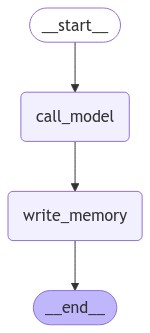

In [91]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memory in the system prompt
    system_msg = f"""You are a helpful assistant with memory that provides information about the user. 
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {existing_memory.value if existing_memory else None}"""

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Create new memory from the chat history and existing memory
    system_msg = f"""Create or update a user profile memory based on the user's chat history. 
    This will be saved for long-term memory. If there is an existing memory, simply update it. 
    Here is the existing memory (it may be empty): {existing_memory.value if existing_memory else None}"""
    user_msg = f"Chat history: {state['messages']}"
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+[HumanMessage(content=user_msg)])

    # Overwrite the existing use profile memory in the store as a JSON object
    key = "user_memory"
    store.put(namespace, key, new_memory.model_dump())

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [92]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco.
================================== Ai Message ==================================

Hi Lance! It's great to meet you. Biking around San Francisco sounds like a fantastic way to explore the city. Do you have any favorite routes or spots you like to visit while biking?


Let's check the memory in the store. 

We can see that the memory is a JSON object that matches our schema.

In [94]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco']}

## Updating profile schema

Each time we run the chatbot, it regenerates the profile from scratch! 

This has at least two issues: 

1. It's inefficient to regenerate the profile from scratch
2. We can loose information when regenerating the profile from scratch

In addition, model can have problems creating or updating complex schemas. 

But what if we could ask the model to *only* update the parts of the schema that have changed?

This is exactly the intuition behind [TrustCall](https://github.com/hinthornw/trustcall)!

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

It's motivated by exactly these challenges from working on memory.

Let's use TrustCall to create a user profile from the following conversation.


In [95]:
conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco."""

We use `create_extractor`, passing in the model as well as our schema and the schema name.

And, we can invoke the extractor with the conversation as a list of [messages](https://python.langchain.com/docs/concepts/messages/).

In [96]:
from trustcall import create_extractor

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",
)

# Instruction
instruction = f"""Extract the user profile from the following conversation:
<convo>
{conversation}
</convo>"""

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)]})
existing_profile = result["responses"][0]
existing_profile

UserProfile(user_name='Lance', interests=['biking around San Francisco'])

In [97]:
existing_profile.model_dump()

{'user_name': 'Lance', 'interests': ['biking around San Francisco']}

Let's see how we can use it to *update* the profile.

TrustCall takes a set of messages as well as the existing JSON schema. 

The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/). 

This is less error-prone than naively overwriting the entire schema.

It's also more efficient since the model only needs to generate the parts of the schema that have changed.

In [98]:
# Update the conversation
updated_conversation = """User: Hi, I'm Lance.
Assistant: Nice to meet you, Lance.
User: I really like biking around San Francisco.
Assistant: San Francisco is a great city! Where do you go after biking?
User: I really like to go to a bakery."""

# Update the instruction
updated_instruction = f"""Update the memory (JSON doc) to incorporate new information from the following conversation:
<convo>
{updated_conversation}
</convo>"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [HumanMessage(content=updated_instruction)], 
                                     "existing": {"UserProfile": existing_profile.model_dump()}})
updated_profile = result["responses"][0]
updated_profile

UserProfile(user_name='Lance', interests=['biking around San Francisco', 'going to a bakery'])

In [99]:
updated_profile.model_dump()

{'user_name': 'Lance',
 'interests': ['biking around San Francisco', 'going to a bakery']}

LangSmith trace:

https://smith.langchain.com/public/b990b271-f570-40f5-927b-437b1287bca8/r
 
For more examples, you can see an overview video [here](https://www.youtube.com/watch?v=-H4s0jQi-QY).

## Chatbot with profile schema updating

Now, let's bring Trustcall into our chatbot to create and update a memory profile.

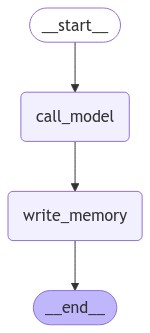

In [100]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile",
)

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memory in the system prompt
    system_msg = f"""You are a helpful assistant with memory that provides information about the user. 
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {existing_memory.value if existing_memory else None}"""

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    # Instructions 
    instruction = f"""Create or update the memory (JSON doc) to incorporate information from the following conversation:
    <convo>
    {list(state['messages'])}
    </convo>"""
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [HumanMessage(content=instruction)], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump(mode="json")

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [101]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [102]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Lance! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


In [103]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-10-28T19:10:47.144473+00:00',
 'updated_at': '2024-10-28T19:10:54.271828+00:00'}

In [104]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

San Francisco has some amazing bakeries! Do you have a favorite bakery you like to visit, or are you looking for recommendations?


Continue the conversation in a new thread.

In [105]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you're in San Francisco and enjoy going to bakeries, here are a few recommendations you might like:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit for any bakery enthusiast.

2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.

3. **Arsicault Bakery** - Renowned for its croissants, which have been praised as some of the best in the country.

4. **Craftsman and Wolves** - A modern patisserie with inventive pastries and a unique twist on traditional favorites.

5. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative baked goods.

I hope you find these suggestions helpful and enjoy exploring them!


Trace:

https://smith.langchain.com/public/effbe8dc-b800-4674-8f3e-9ad72cd66e9c/r

## TODO: Add Studio and closing thoughts 

